In [1]:
import h5py
import numpy as np
import seaborn as sns
import sklearn.preprocessing
import matplotlib.pyplot as plt

# %hist -o -g -f ipython_history.md

In [38]:
import scipy.io
file_path = 'Data/Processed/havsdata.mat'
processed_data = scipy.io.loadmat(file_path)

In [103]:
# Store data as numpy arrays

examples = np.array([example[0] for example in processed_data['processed_data_struct'][0]])
labels = np.array([example[1][0] for example in processed_data['processed_data_struct'][0]])
time_stamps = np.array([example[2][0][0][0] for example in processed_data['processed_data_struct'][0]])

'2020-09-08_09-18-44-944'

## Distribution of examples

<AxesSubplot:title={'center':'Recordings taken on 2020-09-08'}, xlabel='Time', ylabel='Number of Recordings'>

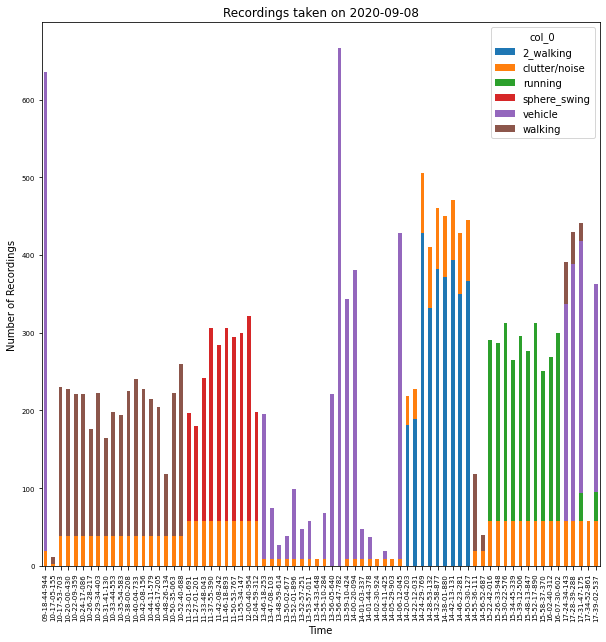

In [111]:
time_stamps_without_date = np.array([time_stamp.split('_')[1] for time_stamp in time_stamps])
pd.crosstab(time_stamps_without_date, labels).plot(kind='bar', stacked=True, figsize=(10,10), 
                                                    fontsize=7, xlabel='Time', ylabel='Number of Recordings',
                                                    title='Recordings taken on 2020-09-08')


# Why is it like this above?

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

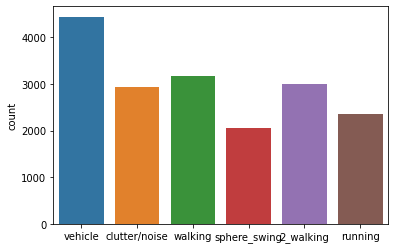

In [176]:
sns.countplot(labels)

In [140]:
max_value_dB = np.amax(examples)
min_value_dB = np.amin(examples)

print(max_value_dB)
print(min_value_dB)

141.54549664506658
-14.828100417399115


In [137]:
# Group data by label
walking_data = examples[np.where(labels == 'walking')]
vehicle_data = examples[np.where(labels == 'vehicle')]
clutter_data = examples[np.where(labels == 'clutter/noise')]
sphere_swing_data = examples[np.where(labels == 'sphere_swing')]
walking_2_data = examples[np.where(labels == '2_walking')]
running_data = examples[np.where(labels == 'running')]

# Get the average image
avg_clutter_image = sum(clutter_data)/len(clutter_data)
avg_vehicle_image = sum(vehicle_data)/len(vehicle_data)
avg_walking_image = sum(walking_data)/len(walking_data)
avg_sphere_swing_image = sum(sphere_swing_data)/len(sphere_swing_data)
avg_running_image = sum(running_data)/len(running_data)
avg_walking_2_image = sum(walking_2_data)/len(walking_2_data)

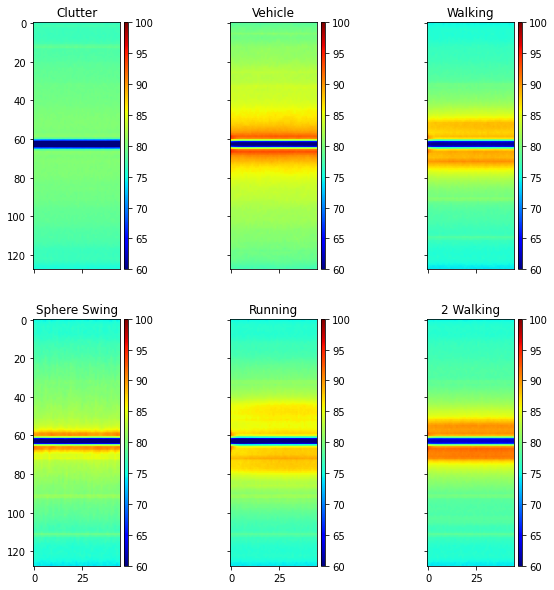

In [144]:
# plt.imshow(avg_walking_2_image, cmap='jet')
# plt.title('Clutter')
# plt.axis('off')
# plt.show()
from mpl_toolkits.axes_grid1 import make_axes_locatable

n = 0
nrows = 2
ncols = 3

classes = ['Clutter', 'Vehicle', 'Walking', 'Sphere Swing', 'Running', '2 Walking']
images = [avg_clutter_image, avg_vehicle_image, avg_walking_image, avg_sphere_swing_image, avg_running_image, avg_walking_2_image]

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 10))

# plt.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), ax=ax)

for row in range(nrows):
    for col in range(ncols):
        img = ax[row, col].imshow((images[n]), cmap='jet', vmin=60, vmax=100)
        ax[row, col].set_title(classes[n])

        divider = make_axes_locatable(ax[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='vertical')

        n += 1

## Analysis of results

Clutter/noise - low values as expected
Vehicle - returns from higher frequencies/speeds compared to returns from humams (expected as vehicles usually travel faster than humans)
Walking - returns from lower freqeuncies/speeds 
Sphere swing - returns are concentrated at lower freqs/speeds because the sphere will always slow down at the top or bottom of the circular path ???
Running - higher freqs/speeds compared to walking and 2 walking as expected
2 walking - higher returns compared to one person walking

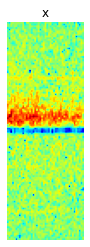

In [148]:
plt.imshow(walking_2_data[1], cmap='jet')
plt.title('x')
plt.axis('off')
plt.show()

In [110]:
def plot_random_spectrogram():
    """Plots a random image from the training data"""
    image_num = np.random.randint(len(havs_data_norm))
    random_image = havs_data_norm[image_num]
    plt.imshow(random_image, cmap='jet')
    plt.title(f'{havs_labels[image_num]}')
    plt.axis('off')
    plt.show()

plot_random_spectrogram()

'clutter/noise'

# Dividing the data

In [240]:
import datetime

# Convert time string to datetime object
datetime_times = np.array([datetime.datetime.strptime(time_stamp, '%H-%M-%S-%f').time() 
                            for time_stamp in time_stamps_without_date
                        ])

# Split 70/15/15 between train, validation and test data
split_ratio = 0.7

x_train, x_val, x_test, y_train, y_val, y_test  = [], [], [], [], [], []

# Walking examples after 13h00 were taken from a further distance
walking_data_after_13h00 = examples[np.where((labels == 'walking') & (datetime_times > datetime.time(13, 00, 00, 000)))]
walking_data_before_13h00 = examples[np.where((labels == 'walking') & (datetime_times < datetime.time(13, 00, 00, 000)))]

# Running examples after 17h28 were taken from a further distance
running_data_after_17h28 = examples[np.where((labels == 'running') & (datetime_times > datetime.time(17, 28, 00, 000)))]
running_data_before_17h28 = examples[np.where((labels == 'running') & (datetime_times < datetime.time(17, 28, 00, 000)))]

havs_data = [vehicle_data, 
            clutter_data, 
            sphere_swing_data, 
            walking_2_data, 
            walking_data_after_13h00, 
            walking_data_before_13h00,
            running_data_after_17h28, 
            running_data_before_17h28]

havs_labels = ['vehicle', 
            'clutter', 
            'sphere_swing', 
            'walking_2', 
            'walking', 
            'walking', 
            'running', 
            'running']

# Split the data
for i, data in enumerate(havs_data):
    train_stop_index = int(split_ratio * len(data))
    val_stop_index = int((split_ratio + (1 - split_ratio)/2)*len(data))

    for j in range(len(data)):
        if j <= train_stop_index:
            # Train set
            x_train.append(data[j])
            y_train.append(havs_labels[i])

        elif j <= val_stop_index:
            # Validation set
            x_val.append(data[j])
            y_val.append(havs_labels[i])

        else:
            # Test set
            x_test.append(data[j])
            y_test.append(havs_labels[i])

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

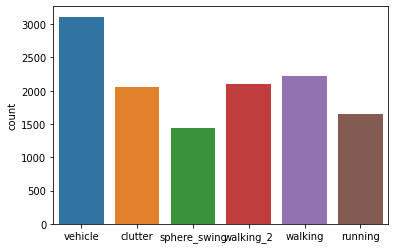

In [233]:
sns.countplot(y_train)

In [234]:
len(y_train) + len(y_val) + len(y_test)

17939

In [235]:
len(labels)

17939

In [236]:
print(len(havs_data))
print(len(classes))
print(len)

8
8
<built-in function len>


In [180]:
datetime_times[0]

datetime.time(9, 18, 44, 944000) > datetime.time(9, 18, 44, 943000)

True

In [14]:
def read_matlab_data(file_path):
    """reading a .mat file to extract the images or the labels"""
    with h5py.File(file_path, 'r') as f:
        print(f"Reading {file_path} . . . ")
        data_keys =  list(f.keys())
        HAVSDatasetStruct = f[data_keys[1]] 
        
        # Read data
        data = HAVSDatasetStruct['Data']
        labels = HAVSDatasetStruct['Label']
        time_stamps = HAVSDatasetStruct['TimeStamp']

        num_of_examples = len(data)

        print(f'There are {num_of_examples} examples available\n')
        
        # examples_data = np.array([np.transpose(f[data[i,0]]) for i in range(num_of_examples)])
        # labels_data =  np.array([''.join(map(chr, np.squeeze(f[labels[i,0]]))) for i in range(num_of_examples)])
        # time_stamps_data =  np.array([''.join(map(chr, np.squeeze(f[time_stamps[i,0]]))) for i in range(num_of_examples)])
        
        # print(f'Finished reading files.')
        print(time_stamps)

        # return examples_data, labels_data, time_stamps_data
        return 1


In [31]:
file_path = 'Data/Processed/havsdata.mat'
with h5py.File(file_path, 'r') as f:
    print(f"Reading {file_path} . . . ")
    data_keys =  list(f.keys())
    HAVSDatasetStruct = f[data_keys[1]] 
    
    # Read data
    data = HAVSDatasetStruct['Data']
    labels = HAVSDatasetStruct['Label']
    time_stamps = HAVSDatasetStruct['TimeStamp']

    num_of_examples = len(data)

    print(f'There are {num_of_examples} examples available\n')
    
    # examples_data = np.array([np.transpose(f[data[i,0]]) for i in range(num_of_examples)])
    # labels_data =  np.array([''.join(map(chr, np.squeeze(f[labels[i,0]]))) for i in range(num_of_examples)])
    # time_stamps_data =  np.array([''.join(map(chr, np.squeeze(f[time_stamps[i,0]]))) for i in range(num_of_examples)])
    
    # print(f'Finished reading files.')

    print(''.join(map(chr, np.squeeze(f[time_stamps[10,0]]))))
    # np.array([''.join(map(chr, np.squeeze(f[time_stamps[i,0]]))) for i in range(num_of_examples)])
    # print(HAVSDatasetStruct)

Reading Data/Processed/havsdata.mat . . . 
There are 17939 examples available



TypeError: iteration over a 0-d array

In [26]:
labels_data.shape

(17939,)

In [15]:
examples, labels, time_stamps = read_matlab_data('Data/Processed/havsdata.mat')


Reading Data/Processed/havsdata.mat . . . 
There are 17939 examples available

<HDF5 dataset "TimeStamp": shape (17939, 1), type "|O">


TypeError: cannot unpack non-iterable int object

In [4]:
# havs stands for human activity, vehicle and sphere
x_train = get_matlab_data('train_data.mat', False)
y_train = get_matlab_data('train_data.mat', True)

# havs stands for human activity, vehicle and sphere
x_test = get_matlab_data('test_data.mat', False)
y_test = get_matlab_data('test_data.mat', True)

# havs stands for human activity, vehicle and sphere
x_val = get_matlab_data('val_data.mat', False)
y_val = get_matlab_data('val_data.mat', True)

Reading train_data.mat . . . 
12554
Completed reading train_data.mat examples data
Reading train_data.mat . . . 
12554
Completed reading train_data.mat labels data
Reading test_data.mat . . . 
2696
Completed reading test_data.mat examples data
Reading test_data.mat . . . 
2696
Completed reading test_data.mat labels data
Reading val_data.mat . . . 
2689
Completed reading val_data.mat examples data
Reading val_data.mat . . . 
2689
Completed reading val_data.mat labels data


In [5]:
from sklearn.utils import shuffle
# Shuffle the data
x_train, y_train = shuffle(x_train, y_train, random_state=1)
x_test, y_test = shuffle(x_test, y_test, random_state=1)
x_val, y_val = shuffle(x_val, y_val, random_state=1)


In [11]:
# Cross Validation Data
x_train_cv = get_matlab_data('train_data_cross_val.mat', False)
y_train_cv = get_matlab_data('train_data_cross_val.mat', True)

x_test_cv = get_matlab_data('test_data_cross_val.mat', False)
y_test_cv = get_matlab_data('test_data_cross_val.mat', True)

Reading train_data_cross_val.mat . . . 
16142
Completed reading train_data_cross_val.mat examples data
Reading train_data_cross_val.mat . . . 
16142
Completed reading train_data_cross_val.mat labels data
Reading test_data_cross_val.mat . . . 
1797
Completed reading test_data_cross_val.mat examples data
Reading test_data_cross_val.mat . . . 
1797
Completed reading test_data_cross_val.mat labels data


In [9]:
from sklearn.utils import shuffle
x_train_cv, y_train_cv = shuffle(x_train_cv, y_train_cv, random_state=1)
x_test_cv, y_test_cv = shuffle(x_test_cv, y_test_cv, random_state=1)


In [13]:
havs_labels.shape

NameError: name 'havs_labels' is not defined

In [5]:
# global_min = np.amin(train_data)
# if global_min > np.amin(test_data):
#     global_min = np.amin(test_data)
# if global_min > np.amin(val_data):
#     global_min = np.amin(val_data)

In [6]:
# global_max = np.amax(train_data)
# if global_max < np.amax(test_data):
#     global_max = np.amax(test_data)
# if global_max < np.amax(val_data):
#     global_max = np.amax(val_data)

In [7]:
# Check the minimum and maximum values in the data
print(global_min)
print(global_max)

-14.828100417399115
141.54549664506658


In [8]:
def data_normaliser(data, global_min, global_max):
    """Normlising examples between 0-1 using the global minimum and maximum"""    
    return (data - global_min)/(global_max - global_min)

# havs_data_norm = data_normaliser(havs_data, global_min, global_max)
x_train =  data_normaliser(train_data, global_min, global_max) # train_data 
x_test = data_normaliser(test_data, global_min, global_max) # test_data
x_val =  data_normaliser(val_data, global_min, global_max) # val_data


In [9]:
# Normalise cross validation data
x_train_cv =  data_normaliser(train_data_cv, global_min, global_max) # train_data 
x_test_cv = data_normaliser(test_data_cv, global_min, global_max) # test_data

NameError: name 'global_min' is not defined

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1. (https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)

In [10]:
# Checking if normalisation has been done

print(np.amin(havs_data_norm))
print(np.amax(havs_data_norm))

NameError: name 'havs_data_norm' is not defined

In [11]:
from sklearn.model_selection import train_test_split
#Creating the train, test and validation set

x_train, x_test, y_train, y_test = train_test_split(havs_data_norm,havs_labels, test_size=0.2, random_state=1) # Random state for reproducibility

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

NameError: name 'havs_data_norm' is not defined

In [18]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(20658, 128, 45)
(2582, 128, 45)
(2587, 128, 45)


In [19]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(20658,)
(2582,)
(2587,)


In [24]:
# Creating a count plot
sns.countplot(havs_labels)

KeyboardInterrupt: 

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

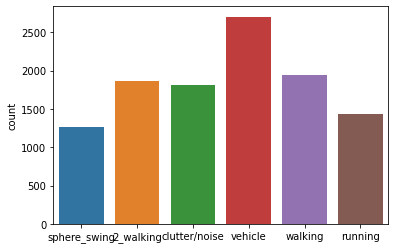

In [21]:
sns.countplot(y_train)

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

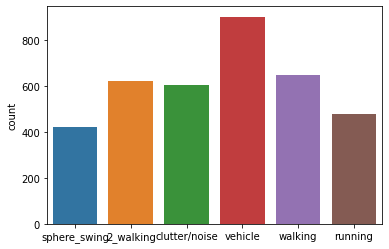

In [22]:
sns.countplot(y_test)

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

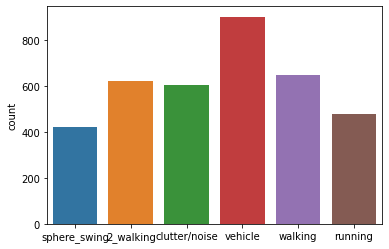

In [23]:
sns.countplot(y_val)

The dataset is not balanced and this will need to be adressed before training.

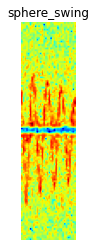

In [22]:
def plot_random_spectrogram():
    """Plots a random image from the training data"""
    image_num = np.random.randint(len(havs_data_norm))
    random_image = havs_data_norm[image_num]
    plt.imshow(random_image, cmap='jet')
    plt.title(f'{havs_labels[image_num]}')
    plt.axis('off')
    plt.show()

plot_random_spectrogram()


On plotting random images, there is evidence that some of the examples in the dataset are not clean. There are files with birds, there is a DC component, there seems to be mislabelling of some nature - the slice taken can be the end or beginning of am file.

In [23]:
walking_data = x_train[np.where(y_train == 'walking')]
vehicle_data = x_train[np.where(y_train == 'vehicle')]
clutter_data = x_train[np.where(y_train == 'clutter/noise')]
sphere_swing_data = x_train[np.where(y_train == 'sphere_swing')]
walking_2_data = x_train[np.where(y_train == '2_walking')]
running_data = x_train[np.where(y_train == 'running')]

avg_clutter_image = sum(clutter_data)/len(clutter_data)
avg_vehicle_image = sum(vehicle_data)/len(vehicle_data)
avg_walking_image = sum(walking_data)/len(walking_data)
avg_sphere_swing_image = sum(sphere_swing_data)/len(sphere_swing_data)
avg_running_image = sum(running_data)/len(running_data)
avg_walking_2_image = sum(walking_2_data)/len(walking_2_data)

In [24]:
avg_clutter_image = sum(clutter_data)/len(clutter_data)
avg_vehicle_image = sum(vehicle_data)/len(vehicle_data)
avg_walking_image = sum(walking_data)/len(walking_data)
avg_sphere_swing_image = sum(sphere_swing_data)/len(sphere_swing_data)
avg_running_image = sum(running_data)/len(running_data)
avg_walking_2_image = sum(walking_2_data)/len(walking_2_data)


ZeroDivisionError: division by zero

In [92]:
avg_clutter_image.shape

(128, 32)

In [24]:
my_dpi = 80
fig = plt.figure(figsize=(20, 10), dpi=my_dpi)
print(fig)

fig.suptitle('Plot of average image in each class', fontsize=20)

# Add plots
ax1 = fig.add_subplot(2, 3, 1)
cs = ax1.imshow(avg_clutter_image, cmap='jet')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax1.set_yticklabels([300, 200, 100, 0, 100, 200, 300])
ax1.set_xticks([0, 34, 69, 104])
ax1.set_xticklabels([0, 1, 2, 3])  

ax1.set_title('Clutter/Noise',   
             fontsize = 14) 

ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(avg_vehicle_image, cmap='jet')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Vehicle',   
             fontsize = 14)
ax2.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax2.set_yticklabels([300, 200, 100, 0, 100, 200, 300])
ax2.set_xticks([0, 34, 69, 104])
ax2.set_xticklabels([0, 1, 2, 3])  

ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(avg_walking_image, cmap='jet')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Walking',   
             fontsize = 14)
ax3.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax3.set_yticklabels([300, 200, 100, 0, 100, 200, 300]) 
ax3.set_xticks([0, 34, 69, 104])
ax3.set_xticklabels([0, 1, 2, 3])  

ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(avg_walking_2_image, cmap='jet')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('2_walking',   
             fontsize = 14) 
ax4.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax4.set_yticklabels([300, 200, 100, 0, 100, 200, 300])
ax4.set_xticks([0, 34, 69, 104])
ax4.set_xticklabels([0, 1, 2, 3])               

ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(avg_running_image, cmap='jet')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Frequency (Hz)')
ax5.set_title('Running',   
             fontsize = 14)
ax5.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax5.set_yticklabels([300, 200, 100, 0, 100, 200, 300]) 
ax5.set_xticks([0, 34, 69, 104])
ax5.set_xticklabels([0, 1, 2, 3])              

ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(avg_sphere_swing_image, cmap='jet')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Frequency (Hz)')
ax6.set_title('Shere Swing',   
             fontsize = 14) 
ax6.set_yticks([10,  28, 46, 64, 82, 100, 118])
ax6.set_yticklabels([300, 200, 100, 0, 100, 200, 300])
ax6.set_xticks([0, 34, 69, 104])
ax6.set_xticklabels([0, 1, 2, 3]) 

fig.colorbar(cs)
fig.savefig('Subplot_avg_images.png')

Figure(1600x800)


NameError: name 'avg_clutter_image' is not defined

Text(0.5, 1.0, 'Walking')

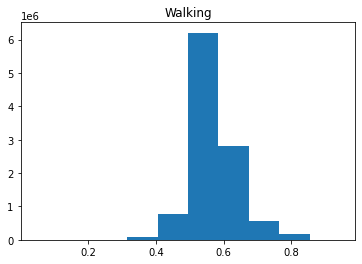

In [25]:
plt.hist(walking_data.flatten())
plt.title("Walking")

Text(0.5, 1.0, 'Running')

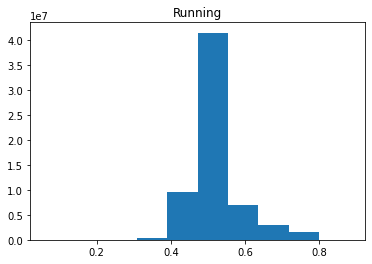

In [390]:
plt.hist(running_data.flatten()) 
plt.title("Running")

Text(0.5, 1.0, 'Vehicle')

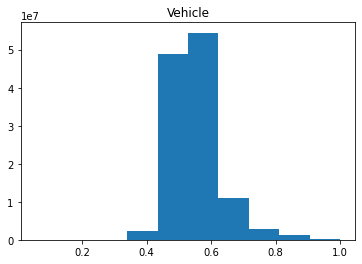

In [391]:
plt.hist(vehicle_data.flatten())
plt.title("Vehicle")

Text(0.5, 1.0, 'Clutter/noise')

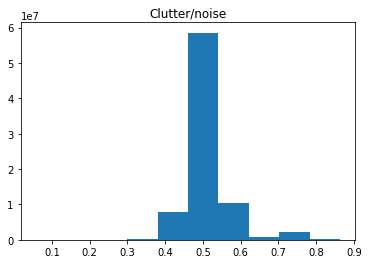

In [392]:
plt.hist(clutter_data.flatten())
plt.title("Clutter/noise")

Text(0.5, 1.0, 'Sphere Swing')

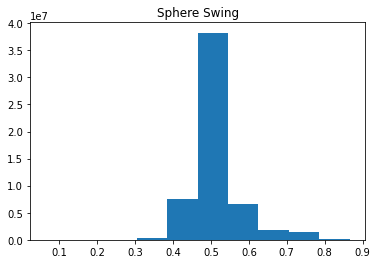

In [393]:
plt.hist(sphere_swing_data.flatten())
plt.title("Sphere Swing")

Text(0.5, 1.0, '2_Walking')

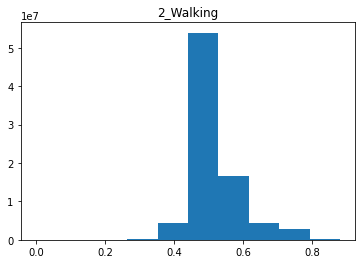

In [394]:
plt.hist(walking_2_data.flatten())
plt.title("2_Walking")

In [12]:
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed

# # save to npy file
# savez_compressed('C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data.npz', x_train=x_train, x_test=x_test, x_val=x_val, y_train=y_train, y_test=y_test, y_val=y_val)

# save to npy file cross validation data
savez_compressed('C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data_cv.npz', x_train=x_train_cv, x_test=x_test_cv, y_train=y_train_cv, y_test=y_test_cv)

In [8]:
mat['time_stamps_array']

array([[array(['2020-09-08_09-18-44-944'], dtype='<U23'),
        array(['2020-09-08_09-18-44-944'], dtype='<U23'),
        array(['2020-09-08_09-18-44-944'], dtype='<U23'), ...,
        array(['2020-09-08_17-39-02-537'], dtype='<U23'),
        array(['2020-09-08_17-39-02-537'], dtype='<U23'),
        array(['2020-09-08_17-39-02-537'], dtype='<U23')]], dtype=object)

In [3]:
import numpy as np
import h5py
f = h5py.File('classes_array.mat','r')
p = h5py.File('time_stamps.mat','r')
data_keys =  list(p.keys())
data_keys
data = f.get('classes_array')
num_of_examples = len(data)

classes = np.array([''.join(map(chr, np.squeeze(f[data[i,0]]))) for i in range(num_of_examples)]) # For converting to a NumPy array
# examples_data = np.array([np.transpose(f[data[i,0]]) for i in range(num_of_examples)])

In [4]:
f = h5py.File('time_stamps.mat','r')
data_keys =  list(p.keys())
data_keys
data = f.get('time_stamps_array')
num_of_examples = len(data)

time_stamps = np.array([''.join(map(chr, np.squeeze(f[data[i,0]]))) for i in range(num_of_examples)]) # For converting to a NumPy array

In [5]:
import pandas as pd
df = pd.DataFrame(list(zip(time_stamps, classes)),
               columns =['Time Stamps', 'Classes']
                )



In [6]:
unique_time_stamps = np.unique(time_stamps)
len(unique_time_stamps)


my_dict ={}

for time_stamp in unique_time_stamps:
    x = np.where(time_stamps==time_stamp)
    my_dict['time_stamp'] = classes[x]
    


In [7]:
time_stamps_without_date = np.array([time_stamp.split('_')[1] for time_stamp in time_stamps])

In [8]:
time_stamps

array(['2020-09-08_09-18-44-944', '2020-09-08_09-18-44-944',
       '2020-09-08_09-18-44-944', ..., '2020-09-08_17-39-02-537',
       '2020-09-08_17-39-02-537', '2020-09-08_17-39-02-537'], dtype='<U23')

<AxesSubplot:title={'center':'Recordings taken on 2020-09-08'}, xlabel='Time', ylabel='Number of Recordings'>

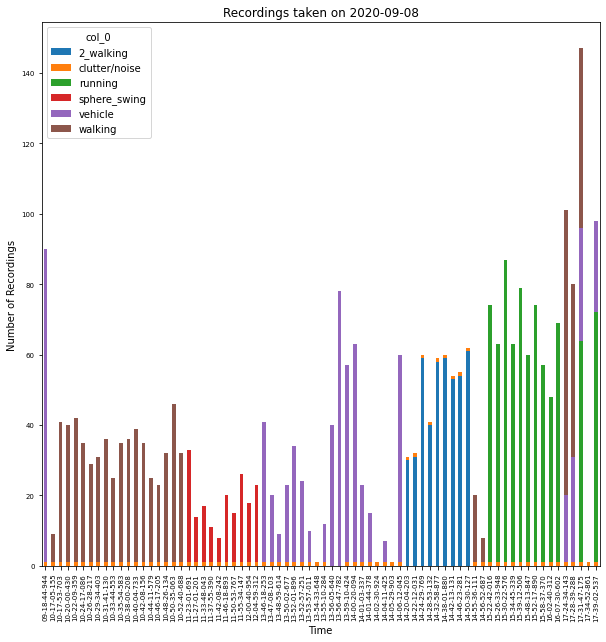

In [9]:
time_stamps_without_date = np.array([time_stamp.split('_')[1] for time_stamp in time_stamps])
pd.crosstab(time_stamps_without_date, classes).plot(kind='bar', stacked=True, figsize=(10,10), 
                                                    fontsize=7, xlabel='Time', ylabel='Number of Recordings',
                                                    title='Recordings taken on 2020-09-08')

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

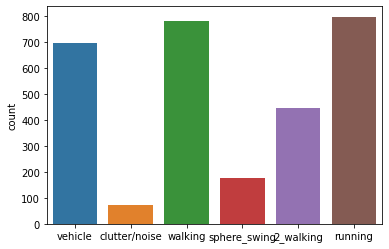

In [74]:
import seaborn as sns
sns.countplot(classes)

<BarContainer object of 2968 artists>

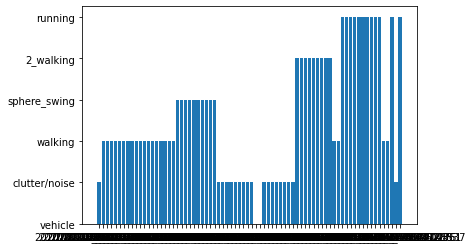

In [23]:
import matplotlib.pyplot as plt
plt.bar(time_stamps, classes)

In [4]:
def get_matlab_data(file_path, is_label: bool):
    """reading a .mat file to extract the images or the labels"""
    with h5py.File(file_path, 'r') as f:
        print(f"Reading {file_path} . . . ")
        data_keys =  list(f.keys())
        HAVSDatasetStruct = f[data_keys[1]] 
        data = HAVSDatasetStruct['Data']
        labels = HAVSDatasetStruct['Label']
        num_of_examples = len(data)

        print(num_of_examples)
        if is_label: # If label file
            labels_data =  np.array([''.join(map(chr, np.squeeze(f[labels[i,0]]))) for i in range(num_of_examples)])
            print(f"Completed reading {file_path} labels data")

            return labels_data  

        else: # If data file
            examples_data = np.array([np.transpose(f[data[i,0]]) for i in range(num_of_examples)])
            print(f"Completed reading {file_path} examples data")

            return examples_data

array([[<HDF5 object reference>],
       [<HDF5 object reference>],
       [<HDF5 object reference>],
       ...,
       [<HDF5 object reference>],
       [<HDF5 object reference>],
       [<HDF5 object reference>]], dtype=object)

## Reading .mat files

In [49]:
# import numpy as np
# import h5py
# f = h5py.File('C:/Users/nyasha/Desktop/Masters-Nyasha/Preprocessing/Data/Unprocessed/2020-09-08_09-18-44-944_trkdata.mat','r')
# data_keys =  list(p.keys())
# C:\Users\nyasha\Desktop\Masters-Nyasha\Preprocessing\Data\Unprocessed\2020-09-08_17-24-34-143_trkdata.mat
# data_keys

from mat4py import loadmat

data = loadmat('C:/Users/nyasha/Desktop/Masters-Nyasha/Preprocessing/Data/Unprocessed/2020-09-08_17-24-34-143_trkdata.mat')

In [51]:
len(data['trkdata']['trk_data_real'])
complex_recordings = []
for real_data, imag_data in zip(data['trkdata']['trk_data_real'], data['trkdata']['trk_data_imag']):
    complex_recording = np.empty(len(real_data), dtype=np.complex64)
    for i, (real_value, imag_value) in enumerate(zip(real_data, imag_data)):
        complex_recording[i] = complex(real_value[0], imag_value[0])
    complex_recordings.append(complex_recording)    


In [53]:
complex_recordings[1]

array([35913.098 +5213.4893j, 35133.746  +861.4445j,
       30559.053 +1527.1968j, ..., 41024.383+18760.025j ,
       42561.72 +18392.498j , 44025.68 +18884.693j ], dtype=complex64)

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\scipy\signal\spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
<ipython-input-92-c25d858dd25f>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, 20*np.log10(abs(Zxx)))


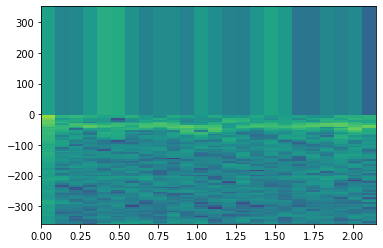

In [92]:
import scipy.signal as signal
from matplotlib import pyplot as plt

num_range_bins = 36000
fs = 714 # Sampling frequency
nperseg = 128 # Length of each segment
noverlap = 64 # Number of overlapping points between segments
nfft = 128 # Length of FFT
dwell_time = 4
slice_width = 45
overlap = 0.5
num_points = np.int64(np.floor(dwell_time* fs))
classified_imgs = 0
num_loops = 10

f, t, Zxx = signal.stft(complex_recordings[10], fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=False, return_onesided=True, axis=-1)
plt.pcolormesh(t, f, 20*np.log10(abs(Zxx)))

In [90]:
window = torch.hamming_window(128)

In [91]:
d

tensor([[-1.4748e+06+2460106.0000j, -1.3930e+06+2228182.2500j,
         -1.3749e+06+2296890.7500j,  ...,
         -1.7286e+06+2431323.7500j, -1.8323e+06+2512998.5000j,
         -1.9523e+06+2501026.7500j],
        [ 7.8446e+05-961092.0000j,  6.7073e+05-940408.0000j,
          5.7425e+05-1025130.1250j,  ...,
          6.7808e+05-1072029.8750j,  7.9241e+05-1105517.0000j,
          8.1879e+05-1075246.5000j],
        [-1.4362e+05-94090.3750j, -6.7918e+04-39570.4414j,
         -3.3751e+04+85401.5625j,  ...,
          3.0905e+04-3379.1294j,  1.1040e+04+11002.3184j,
          3.6062e+02+4710.6855j],
        ...,
        [-2.3677e+03+22450.8477j, -1.7090e+04-36279.6133j,
          1.3032e+03+23629.6562j,  ...,
          8.6150e+03-49638.4375j,  9.6586e+03-30911.0312j,
          2.1432e+04+68886.9922j],
        [-5.3933e+04-37719.1562j,  2.2581e+04-72279.4062j,
          4.7521e+04-19855.6309j,  ...,
         -1.4139e+04-3249.4045j,  5.3504e+04+15948.3340j,
         -3.6457e+04-37463.3984j],
   

In [89]:
import torch
x = torch.from_numpy(complex_recordings[10])
d = torch.stft(x, nfft, hop_length=64, win_length=128, window=window, center=False, normalized=False, onesided=False, return_complex=True)
# plt.pcolormesh(t, f, 20*np.log10(abs(np.array(d))))